# Simulation of EGF stimulation in drug-adapted BRAF<sup>V600E</sup> melanoma cells using the MARM1 model

Here you can simulate the time-course respose of drug-adapted BRAF<sup>V600E</sup> melanoma cells to addition of exogenous EGF. This code simulates the time-course response of A375 melanoma cells adapted to a dose of RAF (vemurafenib) and/or MEK inhibitors (cobimetinib) and then stimulated with EGF.

**Note**: this code performs the simulation for a single condition and visualizes the time-course response. Use the Jupyter Notebook *MARM1_simulation_multiple_conditions.ipynb* to generate simulation results for multiple conditions (e.g. multiple dose combinations). 



## Import of libraries
Importing libraries necessary to run MARM1 model simulations.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
from tqdm.notebook import tqdm, trange

In [2]:
multiprocessing.cpu_count()

28

Importing the MARM1 PySB model and the simulator.  

In [3]:
from pysb.simulator import ScipyOdeSimulator
from pysb.core import as_complex_pattern
from pysb.bng import generate_equations

from MARM2_no_EGFR_no_BRAF import model

## User-defined experimental setup
In this section you can alter the setup of the experiment simulated by MARM1. First, you need to define the experimental setup of the pre-treatment phase and of the subsequent ligand stimulation phase. The variables needed for the pre-treatment phase are:

<b>RAFi_concentration ($\mu$M)</b>: defines the concentration of the RAF inhibitor (vemurafenib) during the pre-treatment and treatment phase. 

<b>MEKi_concentration ($\mu$M)</b>: defines the concentration of the RAF inhibitor (vemurafenib) during the pre-treatment and treatment phase. 

<b>Pretreatment_time (h)</b>: defines the duration of the pre-treatment phase.
    
For the treatment phase, you need to set the concentration of the EGF ligand and the running time of simulation after ligand stimulation. This is done with the following variables:

<b>EGF_concentration (ng/mL)</b>: defines the EGF concentrations used to stimulate cells. We have calibrated the model only using data from 100 ng/mL, which is thus the default value.

<b>Simulation_time (h)</b>: define the simulation time after ligand stimulation. For the stimulation of cells expressing normal levels of EGFR, 2 hours is enough to visualize the pulsatile reactivation of MAPK signaling.

<b>N_time_points</b>: define the number of time points returned by each model simulation. 

Choose the experiment to simulate by setting the following variables and re-running the notebook:

1. **PRAF inhibitor** pre-treatment concentration in μM.

2. **MEK inhibitor** pre-treatment concentration in μM.

3. **Pretreatment duration** in hours.

In [4]:
t_pretrt = 24

5. **Simulation time** in hours.

In [5]:
t_trt = 24

6. **Parameter set** selects which of the 50 best-fit parameter sets to use for the simulation. Set 0 is the best fit and 49 the worst.

In [6]:
param_set_index = 13
# param_set_index = 0

7. **N_time_points** defineds the number of time points returned by each individual model simulation

In [7]:
N_time_points = 97

## Generate model equations
PySB runs BioNetGen to generate the reaction network

In [8]:
generate_equations(model)
#[i.name for i in model.parameters]

## Parameter set preparation

Override the `EGFR_crispr` parameter with the user-specified value for EGFR under/over-expression and set naive-treatment conditions for concentrations of RAF and MEK inhibitors and EGF.

In [9]:
param_sets = pd.read_csv('RTKERK_pRAF_EGF_EGFR_MEKi_PRAFi_RAFi.csv', index_col=0)
# finds the parameters of the .csv file that correspond to Cobimetinib and Vemurafenib and maps them to MEKi and RAFi (respectively)
rename_dict = {}
for i in param_sets.columns:
    if "Cobimetinib" in i or "Vemurafenib" in i:
        rename_dict[i] = i.replace("Cobimetinib","MEKi").replace("Vemurafenib","RAFi")
param_sets = param_sets.rename(columns = rename_dict)

# finds the parameters which are stored in .csv file but not in the model and removes them
csv_spec_params = set(param_sets.columns)-(set(param_sets.columns)&set([i.name for i in model.parameters]))
param_sets = param_sets.drop(csv_spec_params, axis=1)

# Reduces GTP hydrolysis to align with expected GTPase activity of NRASQ61mut
param_sets["catalyze_NF1_RAS_gdp_kcatr"] = param_sets["catalyze_NF1_RAS_gdp_kcatr"] / 100
# Reduces removes preference against second inhibitor binding to model pan RAF inhibitor
param_sets["ep_RAF_RAF_mod_RAFi_double_ddG"] = 0
params = param_sets.iloc[param_set_index].to_dict()

In [10]:
#params['EGF_0'] = 0.0
params['RAFi_0'] = 0.0
params['MEKi_0'] = 0.0

In [11]:
print(model.parameters.NRAS_Q61mut.value)
print(model.parameters.catalyze_NF1_RAS_gdp_kcatr.value)
print(model.parameters.q61_RAS_gtp_kcat.value)
print(model.parameters.ep_RAF_RAF_mod_RAFi_single_ddG.value)
print(model.parameters.ep_RAF_RAF_mod_RAFi_double_ddG.value)
#print(model.parameters.bind_PRAFi_RAF_kf.value)

1.0
0.0020668423117604
0.01
0.0
0.0


## Simulations

First we define some utility functions that will be used below.
*Equilibrate* runs a model simulation till steady state for that parameter set.
*Get_species_index* find and retunrs the index of speies in the model given input specie patterns. 

In [12]:
def equilibrate(simulator, initials,verbose = True):
    """Simulate a model from given initial conditions until it reaches steady state"""
    scale = 10
    t_start = 10
    df = None
    tspan = np.geomspace(t_start, t_start * scale)
    while True:
        if verbose:
            print(f"    at t={tspan[-1]:<5.3g} ... ", end='', flush=True)
        res = simulator.run(tspan=tspan, initials=initials)
        df = pd.concat([df, res.dataframe.iloc[1:]])
        initials = res.species[-1]
        close = np.isclose(
            *res.species[[-1,-2]].view(float).reshape(2,-1),
            rtol=1e-3
        )
        cs = np.sum(close)
        n = len(simulator.model.species)
        if verbose:
            print(f"{cs}/{n} species converged")
        if np.all(close):
            break
        tspan *= scale
    return df

In [13]:
def get_species_index(model, pattern):
    """Return the integer species number for a given species in the model"""
    pattern = as_complex_pattern(pattern)
    matches = [
        i for i, s in enumerate(model.species)
        if s.is_equivalent_to(pattern)
    ]
    n = len(matches)
    assert n == 1, f"Expected exactly one match, got {n}"
    return matches[0]

## Initial equilibrium
First we run the model from its baseline initial conditions until equilibrium is reached. For example protein synthesis/degradation, phosphorylation/dephosphorylation, and drug binding/unbinding all need to reach steady state to match the state of the cells in the experimental setup. There may be some time without visible progress as behind the scenes PySB runs BioNetGen to generate the reaction network and Cython to compile the resulting differential equations into efficient executable code.

In [14]:
sim = ScipyOdeSimulator(model,param_values=params) 
df_eq = equilibrate(sim, None)

    at t=100   ... 877/877 species converged


Now that the model has been simulated once and the actual molecular species have been enumerated, we can find the exact species numbers for the inhibitors and EGF. These are needed so that their concentrations can be overridden in the model state for subsequent simulations.

In [15]:
df_eq

,__s0,__s1,__s2,__s3,__s4,__s5,__s6,__s7,__s8,__s9,...,tCRAF_obs,tRAS_obs,tMEK_obs,pMEK_obs,pMEK_IF_obs,tERK_obs,pERK_obs,pERK_IF_obs,tDUSP_obs,tmDUSP_obs
time,,,,,,,,,,,,,,,,,,,,,
10.481131,0.000092,0.524546,0.000000e+00,0.112642,0.000000e+00,0.000102,1.699603e-07,-2.014699e-24,0.000632,-1.665002e-27,...,9.335252,12.667368,11.694416,0.193542,0.646927,12.099233,0.867748,1.853092,7.738456,5.830010
10.985411,0.000121,0.522784,0.000000e+00,0.058080,0.000000e+00,0.000304,3.632386e-07,-5.961302e-25,0.000423,-3.577027e-29,...,9.335252,12.667368,11.694416,0.388886,1.216233,12.099233,0.752616,1.618830,9.305731,6.503266
11.513954,0.000136,0.521404,0.000000e+00,0.037409,0.000000e+00,0.000501,5.037248e-07,-1.723721e-24,0.000303,-1.551829e-30,...,9.335252,12.667368,11.694416,0.484712,1.495505,12.099233,0.693531,1.498608,9.893594,6.682482
12.067926,0.000141,0.520338,0.000000e+00,0.028523,0.000000e+00,0.000648,5.845809e-07,-2.470099e-25,0.000238,-1.019987e-22,...,9.335252,12.667368,11.694416,0.538950,1.653573,12.099233,0.663503,1.437509,10.172126,6.736336
12.648552,0.000140,0.519526,0.000000e+00,0.024413,0.000000e+00,0.000731,6.201328e-07,-2.412750e-25,0.000201,-1.432847e-22,...,9.335252,12.667368,11.694416,0.572906,1.752535,12.099233,0.650824,1.411712,10.310353,6.749114
13.257114,0.000136,0.518918,0.000000e+00,0.022439,0.000000e+00,0.000767,6.286510e-07,-3.680712e-25,0.000179,-2.134514e-23,...,9.335252,12.667368,11.694416,0.595237,1.817615,12.099233,0.647469,1.404885,10.378314,6.750520
13.894955,0.000132,0.518469,0.000000e+00,0.021460,0.000000e+00,0.000776,6.246015e-07,-7.920837e-25,0.000166,3.930117e-22,...,9.335252,12.667368,11.694416,0.610291,1.861487,12.099233,0.648281,1.406537,10.411132,6.750710
14.563485,0.000129,0.518144,0.000000e+00,0.020946,0.000000e+00,0.000775,6.166578e-07,-2.827370e-23,0.000157,4.183557e-23,...,9.335252,12.667368,11.694416,0.620550,1.891385,12.099233,0.650365,1.410777,10.427183,6.751990
15.264180,0.000126,0.517912,0.000000e+00,0.020652,0.000000e+00,0.000772,6.089060e-07,1.091703e-21,0.000151,8.036643e-23,...,9.335252,12.667368,11.694416,0.627553,1.911795,12.099233,0.652389,1.414895,10.435647,6.754037


In [16]:
RAFi_index = get_species_index(model, model.monomers.RAFi(raf=None)**model.compartments.CP)
MEKi_index = get_species_index(model, model.monomers.MEKi(mek=None)**model.compartments.CP)
#EGF_index = get_species_index(model, model.monomers.EGF(rtk=None)**model.compartments.CP)

## Inhibitor pre-treatment

We take the final state of the equilibration simulation and use it as the initial state of this new simulation, overriding the RAFi and MEKi concentrations with the user-selected values.

In [17]:
initials_pre = df_eq.iloc[-1, :len(model.species)].copy()
initials_pre[RAFi_index] = 0.0
initials_pre[MEKi_index] = 0.0
#initials_pre[EGF_index] = 0.0

#fixed time pre-treatment simulation
tspan_pretrt = np.linspace(0, t_pretrt, N_time_points)
df_pre=sim.run(tspan=tspan_pretrt, initials=initials_pre.to_list()).dataframe

#run pre-tretment to steady state instead of using specified time  
#df_pre = equilibrate(sim, initials_pre)

In case the previous simulation was run to steady state, we want to retain only the first t_pretrt hours of pre-treatment plus the state at final equilibrium. So we cut the time series down using a Pandas slice operation and adjust the remaining time values to begin at -pre_time_max.

In [18]:
if (len(df_pre.loc[:t_pretrt])<len(df_pre)):
   df_pre_tmp = df_pre.loc[:t_pretrt]
   df_pre_tmp.iloc[-1] = df_pre.iloc[-1]
   df_pre= df_pre_tmp
df_pre['time'] = df_pre.index
df_pre['time'] = df_pre['time']-t_pretrt
df_pre['time'].iloc[-1] = 0
df_pre.reset_index(drop=True, inplace=True)
df_pre.set_index('time', inplace=True)

## Inhibitor treatment

We run another simulation starting from the final state of the pre-treatment simulation, overriding the MEKi and PRAFi concentrations with the user-selected values. This is a fixed-time simulation rather than the steady-state equilibration used in the previous simulations.

In [49]:
#set the dilution range for the PRAF inhibitor, which is x axis
#RAFi_dil=np.logspace(-4, 1, 20); #uM
RAFi_dil=np.logspace(-4, 1, 20); #uM
#set the dilution range for the MEK inhibitor, each value generates a curve
#MEKi_dil=np.logspace(-4, 1, 7); #uM
MEKi_dil=np.logspace(-4, 1, 7); #uM
#set the values of f and g to model RAF inhibitors with different complex drug-protein interactions
#1st generation: f= 0.001, g=1000; panRAF: f= 0.001, g=1; dimer selective f=1, g=0.001
# Moved from using f and g to single and double ddG values (respectively), currently reads from model, but can be perturbed if needed
s_ddG=[params["ep_RAF_RAF_mod_RAFi_single_ddG"]];
d_ddG=[params["ep_RAF_RAF_mod_RAFi_double_ddG"]];
fgtitle=['pan_RAF'];

In [ ]:
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap

#create a bar to keep track of simulation progress
p_bar_sim = tqdm(desc='Simulation progress', total=len(s_ddG)*len(MEKi_dil)*len(RAFi_dil))

#define observables to plot
plt_obs=['pMEK', 'pMEK_obs', 'pERK', 'pERK_obs'];
plot_obs_names=['pMEK', 'pMEK/tMEK', 'pERK', 'pERK/tERK'];

#define figure 
fig, ax = plt.subplots(len(plt_obs),len(d_ddG), figsize=(8, 12), sharey=True);
fig.suptitle("Simulations of RAF inhibitor effect on RAF activity");  

#define plot colors
colors = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
cmap = LinearSegmentedColormap.from_list(
        "Custom", colors, N=20)
#cmap=plt.get_cmap('winter');
col=cmap(np.linspace(0.0, 1.0, len(MEKi_dil)))[::-1];

#simulate the different parameter combinations
ss_v = np.empty([len(RAFi_dil), len(plt_obs)]);
for i in range (len(s_ddG)):
    for j in range(len(MEKi_dil)):
        for k in range(len(RAFi_dil)):
            print(j/len(MEKi_dil),k/len(RAFi_dil))
            #run simulation with modified parameters
            params.update({'ep_RAF_RAF_mod_RAFi_single_ddG': s_ddG[i] ,'ep_RAF_RAF_mod_RAFi_double_ddG': d_ddG[i], 'MEKi_0': MEKi_dil[j], 'RAFi_0': RAFi_dil[k]});
            #run this to assure model is run to steady_ state, 
            sim = ScipyOdeSimulator(model,param_values=params) 
            res = equilibrate(sim, None,verbose=False)
            #update progress
            p_bar_sim.update(1);
            #extract end of simulation for each osbervables from the dataframe of simulation results
            ss_v[k,:]=res[plt_obs].iloc[-1];
        #plot the results for a given RR_KD and f,g combination
        for z in range(len(plt_obs)):
            #plot simualtion
            if len(s_ddG) == 1:
                h=ax[z].plot(RAFi_dil, ss_v[:,z], color = col[j,:]);   
                ax[z].set_xscale('log');
                #set axis names
                if (i==0):
                    ax[z].set_ylabel(plot_obs_names[z]);
                if (z==0):
                    ax[z].title.set_text(fgtitle[i]);
                if (z==(len(plt_obs)-1)):
                    ax[z].set_xlabel('RAFi_0 (uM)');
                else:
                    ax[z].set_xticklabels([]);
            else:
                h=ax[z,i].plot(RAFi_dil, ss_v[:,z], color = col[j,:]);   
                ax[z,i].set_xscale('log');
                #set axis names
                if (i==0):
                    ax[z,i].set_ylabel(plot_obs_names[z]);
                if (z==0):
                    ax[z,i].title.set_text(fgtitle[i]);
                if (z==(len(plt_obs)-1)):
                    ax[z,i].set_xlabel('RAFi_0 (uM)');
                else:
                    ax[z,i].set_xticklabels([]);
                
#add legend
fig.legend(ax, labels= list(map(str, np.round(np.log10(MEKi_dil),2))) , 
           bbox_to_anchor=(1,1), loc="center right", borderaxespad=0.0,
           title="MEKi_0");
#save figures in pdf format
plt.tight_layout()
fig.savefig('./figures/RAS_RAF_RAFi_dose_response.svg',format = 'svg', bbox_inches='tight')
fig.savefig('./figures/RAS_RAF_RAFi_dose_response.pdf',format = 'pdf', bbox_inches='tight')
fig.savefig('./figures/RAS_RAF_RAFi_dose_response.png',format = 'png', bbox_inches='tight')

In [25]:
#set the dilution range for the MEK inhibitor, which is x axis
#RAFi_dil=np.logspace(-4, 1, 20); #uM
MEKi_dil=np.logspace(-4, 1, 20); #uM
#set the dilution range for the PRAF inhibitor, each value generates a curve
#MEKi_dil=np.logspace(-4, 1, 7); #uM
RAFi_dil=np.logspace(-4, 1, 7); #uM
#set the values of f and g to model RAF inhibitors with different complex drug-protein interactions
#1st generation: f= 0.001, g=1000; panRAF: f= 0.001, g=1; dimer selective f=1, g=0.001
# Moved from using f and g to single and double ddG values (respectively), currently reads from model, but can be perturbed if needed
s_ddG=[params["ep_RAF_RAF_mod_RAFi_single_ddG"]];
d_ddG=[params["ep_RAF_RAF_mod_RAFi_double_ddG"]];
fgtitle=['pan_RAF'];

Simulation progress:   0%|          | 0/140 [00:00<?, ?it/s]

0.0 0.0
0.0 0.05
0.0 0.1
0.0 0.15
0.0 0.2
0.0 0.25
0.0 0.3
0.0 0.35
0.0 0.4
0.0 0.45
0.0 0.5
0.0 0.55
0.0 0.6
0.0 0.65
0.0 0.7
0.0 0.75
0.0 0.8
0.0 0.85
0.0 0.9
0.0 0.95
0.14285714285714285 0.0
0.14285714285714285 0.05
0.14285714285714285 0.1
0.14285714285714285 0.15
0.14285714285714285 0.2
0.14285714285714285 0.25
0.14285714285714285 0.3
0.14285714285714285 0.35
0.14285714285714285 0.4
0.14285714285714285 0.45
0.14285714285714285 0.5
0.14285714285714285 0.55
0.14285714285714285 0.6
0.14285714285714285 0.65
0.14285714285714285 0.7
0.14285714285714285 0.75
0.14285714285714285 0.8
0.14285714285714285 0.85
0.14285714285714285 0.9
0.14285714285714285 0.95
0.2857142857142857 0.0
0.2857142857142857 0.05
0.2857142857142857 0.1
0.2857142857142857 0.15
0.2857142857142857 0.2
0.2857142857142857 0.25
0.2857142857142857 0.3
0.2857142857142857 0.35
0.2857142857142857 0.4
0.2857142857142857 0.45
0.2857142857142857 0.5
0.2857142857142857 0.55
0.2857142857142857 0.6
0.2857142857142857 0.65
0.285714285

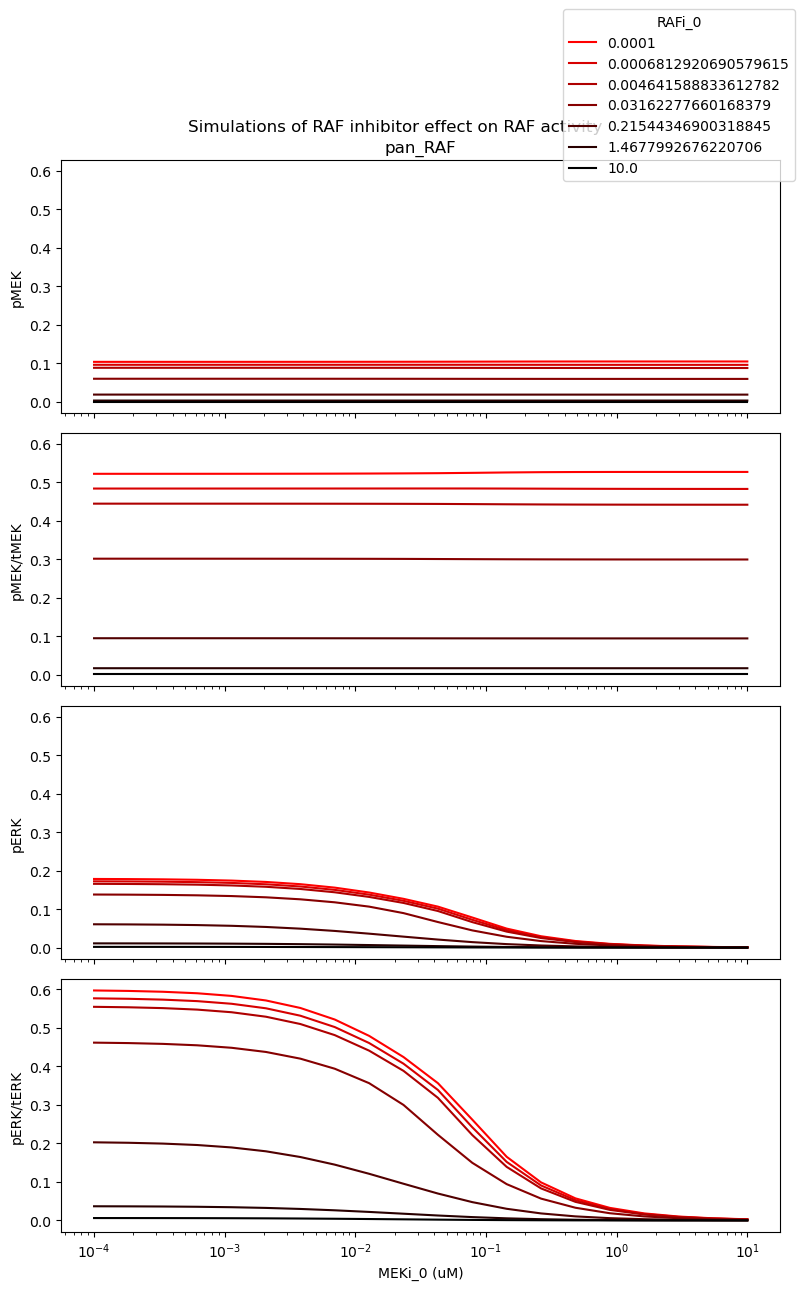

In [26]:
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap

#create a bar to keep track of simulation progress
p_bar_sim = tqdm(desc='Simulation progress', total=len(s_ddG)*len(RAFi_dil)*len(MEKi_dil))

#define observables to plot
plt_obs=['pMEK', 'pMEK_obs', 'pERK', 'pERK_obs'];
plot_obs_names=['pMEK', 'pMEK/tMEK', 'pERK', 'pERK/tERK'];

#define figure 
fig, ax = plt.subplots(len(plt_obs),len(d_ddG), figsize=(8, 12), sharey=True);
fig.suptitle("Simulations of RAF inhibitor effect on RAF activity");  

#define plot colors
colors = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
cmap = LinearSegmentedColormap.from_list(
        "Custom", colors, N=20)
#cmap=plt.get_cmap('winter');
col=cmap(np.linspace(0.0, 1.0, len(RAFi_dil)))[::-1];

#simulate the different parameter combinations
ss_v = np.empty([len(MEKi_dil), len(plt_obs)]);
for i in range (len(s_ddG)):
    for j in range(len(RAFi_dil)):
        for k in range(len(MEKi_dil)):
            print(j/len(RAFi_dil),k/len(MEKi_dil))
            #run simulation with modified parameters
            params.update({'ep_RAF_RAF_mod_RAFi_single_ddG': s_ddG[i] ,'ep_RAF_RAF_mod_RAFi_double_ddG': d_ddG[i], 'RAFi_0': RAFi_dil[j], 'MEKi_0': MEKi_dil[k]});
            #run this to assure model is run to steady_ state, 
            sim = ScipyOdeSimulator(model,param_values=params) 
            res = equilibrate(sim, None,verbose=False)
            #update progress
            p_bar_sim.update(1);
            #extract end of simulation for each osbervables from the dataframe of simulation results
            ss_v[k,:]=res[plt_obs].iloc[-1];
        #plot the results for a given RR_KD and f,g combination
        for z in range(len(plt_obs)):
            #plot simualtion
            if len(s_ddG) == 1:
                h=ax[z].plot(MEKi_dil, ss_v[:,z], color = col[j,:]);   
                ax[z].set_xscale('log');
                #set axis names
                if (i==0):
                    ax[z].set_ylabel(plot_obs_names[z]);
                if (z==0):
                    ax[z].title.set_text(fgtitle[i]);
                if (z==(len(plt_obs)-1)):
                    ax[z].set_xlabel('MEKi_0 (uM)');
                else:
                    ax[z].set_xticklabels([]);
            else:
                h=ax[z,i].plot(MEKi_dil, ss_v[:,z], color = col[j,:]);   
                ax[z,i].set_xscale('log');
                #set axis names
                if (i==0):
                    ax[z,i].set_ylabel(plot_obs_names[z]);
                if (z==0):
                    ax[z,i].title.set_text(fgtitle[i]);
                if (z==(len(plt_obs)-1)):
                    ax[z,i].set_xlabel('MEKi_0 (uM)');
                else:
                    ax[z,i].set_xticklabels([]);
                
#add legend
fig.legend(ax, labels= list(map(str, np.round(np.log10(RAFi_dil),2))) , 
           bbox_to_anchor=(1,1), loc="center right", borderaxespad=0.0,
           title="RAFi_0");
#save figures in pdf format
plt.tight_layout()
fig.savefig('./figures/RAS_RAF_RAFi_dose_response_flipped.svg',format = 'svg', bbox_inches='tight')
fig.savefig('./figures/RAS_RAF_RAFi_dose_response_flipped.pdf',format = 'pdf', bbox_inches='tight')
fig.savefig('./figures/RAS_RAF_RAFi_dose_response_flipped.png',format = 'png', bbox_inches='tight')

Concatenate the dataframes holding the pre-treatment and treatment simulation trajectories, keeping only the columns corresponding to model observables. Also filter out "noise" (insignificant concentration fluctuations caused by numerical integration tolerance issues).

In [ ]:
obs = pd.concat([df_pre, df_trt.iloc[1:]])[df_pre.keys()[len(model.species):]]
obs.loc[:, (obs < 1e-10).all()] = 0

## Write time courses to CSV file

Append information on parameter sets used in this simulation and save the time course trajectories to file.

In [ ]:
settings = {
    'Cell_line': 'A375_sim',
    'Parameter_set': param_set_index,
    'Drug A': 'Vemurafenib',
    'Drug B': 'Cobimetinib',
    'Concentration A (uM)': RAFi_concentration,
    'Concentration B (uM)': MEKi_concentration,
    'Time A (h)': t_pretrt,
    'Time B (h)': t_pretrt,
}
obs_out = obs.copy()
for column, value in settings.items():
     obs_out[column] = value
obs_out.to_csv('trajectories_single_run.csv')

In [ ]:
obs_out

## Plot time courses

Plot time-course trajectories of meaninfgul model species. The pre-treatment timescale is collapsed on a smallar interval for display purposes.

In [ ]:
pre_time_scale = 0.5
obs_plot = obs.reset_index()
time_scale_factor = pre_time_scale / -obs_plot['time'].iloc[0]
obs_plot.loc[obs_plot['time'] < 0, 'time'] *= time_scale_factor

In [ ]:
obs_melted = obs_plot.melt(id_vars='time')
g = sns.FacetGrid(
    obs_melted, col='variable', hue='variable', col_wrap=4,
    sharex=False, sharey=False, height=1.9, aspect=1.25
)
g.map(plt.plot, 'time', 'value')
for ax in g.axes:
    _, ymax = ax.get_ylim()
    ax.set_ylim(ymin=0, ymax=ymax * 1.03)
    ax.set_xticks([-pre_time_scale, 0, 1, t_trt])
    ax.set_xticklabels(['-'+str(t_pretrt), '0', '1', str(t_trt)])
    ax.axvline(0, color='k', linewidth=0.5, linestyle='--')
g.set_titles('{col_name}')
g.set_xlabels('time (hours)')
g.set_ylabels('amount (\u03bcM)')
plt.tight_layout()

# Session Info

In [ ]:
!conda env export --name test_env